In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
from aacgmv2 import convert_mlt
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline
# import the sd-data overlay module
import os
import sys
module_path = os.path.abspath(os.path.join('../py/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import sd_scan_muh

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Some constants
eventDate = datetime.datetime(2016,7,25)
timeStart = datetime.datetime(2016,7,25,3,0)
timeEnd = datetime.datetime(2016,7,25,7,0)
sapsTime = datetime.datetime(2016,7,25,5,30)
sapsRadList = [ "cvw", "cve","fhw",\
               "fhe", "bks", "wal" ]
selBeam = 7
sapsMlatRange = [ 52., 63. ]#[ 56., 60. ]
sapsVelCutoff = 50.
sapsNpointsCutoff = 0 # per radar per beam
velScale = [ -500, 500 ]
velMagnScale = [ 0, 1500 ]

In [3]:
def round2(number):
    """
    Round a number to the closest half integer.
    """
    return round(number * 2) / 2

def get_west_vel(row):
    westVel = row['vLos']/( numpy.cos(\
                 numpy.deg2rad( 90.-\
                    row['azimCalcMag'] ) ) )
    if westVel >= 2000.:
        return numpy.nan
    return westVel


def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )


def get_mlon_from_mlt(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    if row["endPtnormMlt"] < 0: 
        currEndptMLT = row["endPtnormMlt"] + 24.
    else:
        currEndptMLT = row["endPtnormMlt"]
    row["Mlon"] = numpy.round( \
                        convert_mlt( currMLT, row["date"] , m2a=True ) )
    if row["Mlon"] > 180.:
        row["Mlon"] -= 360.
    row["EndptMlon"] = numpy.round( \
                        convert_mlt( currEndptMLT, row["date"] , m2a=True ) )
    if row["EndptMlon"] > 180.:
        row["EndptMlon"] -= 360.
    return row

In [4]:
# read from the feather file
velsDF = feather.read_dataframe('../data/saps-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
velsDF["velMagn"] = numpy.abs(velsDF["vLos"])
velsDF.head()

,dateStr,timeStr,beam,range,azimCalcMag,vLos,MLAT,MLON,MLT,GLAT,GLON,radId,radCode,date,normMLT,velMagn
0,20160725,200,0,0,-31.8579,0.0000,38.6897,-146.2574,11.4109,43.7946,142.2906,41,hkw,2016-07-25 02:00:00,11.4109,0.0000
1,20160725,200,0,1,-35.2038,0.0000,39.0370,-146.7567,11.3776,44.1381,141.7370,41,hkw,2016-07-25 02:00:00,11.3776,0.0000
2,20160725,200,0,2,-37.7155,3.5175,39.3297,-147.2205,11.3467,44.4252,141.2232,41,hkw,2016-07-25 02:00:00,11.3467,3.5175
3,20160725,200,0,3,-39.7328,6.5212,39.6014,-147.6740,11.3165,44.6902,140.7215,41,hkw,2016-07-25 02:00:00,11.3165,6.5212
4,20160725,200,0,4,-41.4199,3.6386,39.8590,-148.1218,11.2866,44.9400,140.2269,41,hkw,2016-07-25 02:00:00,11.2866,3.6386


In [5]:
# filter saps data
# we'll get only those velocities
# which have a westward sense and
# which are greater than cutoff (50 m/s)
velsDF = velsDF[ (numpy.abs(velsDF["vLos"]) >= sapsVelCutoff) &\
               ( (velsDF["vLos"]/velsDF["azimCalcMag"]) > 0.) ].reset_index(drop=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


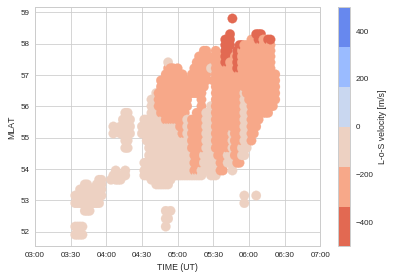

In [6]:
# sel data from a radar
rtiDF = velsDF[ (velsDF["radCode"] == sapsRadList[0]) &\
              (velsDF["beam"] == selBeam) ]
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiDF["dtNum"] = [ date2num(x) for x in rtiDF["date"] ]
plotDF = rtiDF[ ["MLAT", "dtNum",\
                        "vLos"] ].pivot( "MLAT", "dtNum" )
mlatVals = plotDF.index.values
timeVals = plotDF.columns.levels[1].values

timeCntr, mlatCntr  = numpy.meshgrid( timeVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["vLos"].values),plotDF["vLos"].values)
# rtiPlot = ax.pcolormesh(timeCntr, mlatCntr, vLosVals, cmap=seaMap, vmin=velScale[0],vmax=velScale[1])
rtiPlot = ax.scatter( rtiDF["date"].values, rtiDF["MLAT"].values,\
           c=rtiDF["vLos"].values, cmap=seaMap,vmin=velScale[0], vmax=velScale[1], s=90. )

ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


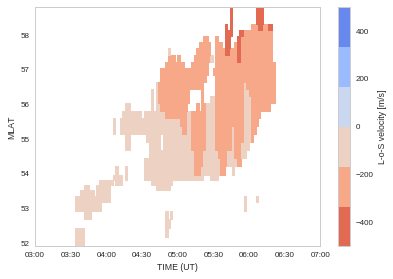

In [7]:
# sel data from a radar
rtiDF = velsDF[ (velsDF["radCode"] == sapsRadList[0]) &\
              (velsDF["beam"] == selBeam) ]
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiDF["dtNum"] = [ date2num(x) for x in rtiDF["date"] ]
plotDF = rtiDF[ ["MLAT", "dtNum",\
                        "vLos"] ].pivot( "MLAT", "dtNum" )
mlatVals = plotDF.index.values
timeVals = plotDF.columns.levels[1].values

timeCntr, mlatCntr  = numpy.meshgrid( timeVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["vLos"].values),plotDF["vLos"].values)
rtiPlot = ax.pcolormesh(timeCntr, mlatCntr, vLosVals, cmap=seaMap, vmin=velScale[0],vmax=velScale[1])
# rtiPlot = ax.scatter( rtiDF["date"].values, rtiDF["MLAT"].values,\
#            c=rtiDF["vLos"].values, cmap=seaMap,vmin=velScale[0], vmax=velScale[1], s=90. )

ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")

In [8]:
# Filter velocities from velsDF
sapsVelsDF = velsDF[ (velsDF["MLAT"] >=sapsMlatRange[0]) &\
                   (velsDF["MLAT"] <=sapsMlatRange[1]) &\
                   (velsDF["range"] >= 5) &\
                   ( numpy.abs(velsDF["azimCalcMag"]) <= 60.) &\
                   ( numpy.abs(velsDF["azimCalcMag"]) >= 10.) ].reset_index(drop=True)

In [9]:
# Group the vel. Magn by rounded MLAT, MLT
sapsVelsDF["mlat_rnd"] = [round2(x) for x in sapsVelsDF["MLAT"] ]
sapsVelsDF["mlon_rnd"] = numpy.round( sapsVelsDF["MLON"] )
sapsVelsDF["mlt_rnd"] = numpy.round( sapsVelsDF["MLT"],2 )
sapsVelsDF["time"] = [ date2num(x) for x in sapsVelsDF["date"] ]

# get estimated SAPS westward velocities
sapsVelsDF["west_vel"] = sapsVelsDF.apply( get_west_vel, axis=1 )

sapsMLonTimeMaxDF = sapsVelsDF[ ["time", "mlon_rnd", "west_vel"]\
                 ].groupby( [ "time", "mlon_rnd" ]\
                ).max().reset_index()
sapsMLonTimeMaxDF.head()

,time,mlon_rnd,west_vel
0,736170.093056,-49.0,147.996685
1,736170.093056,-48.0,202.480152
2,736170.094444,-50.0,183.298845
3,736170.094444,-49.0,238.399766
4,736170.094444,-48.0,254.527349


In [10]:
sapsMlatDF = pandas.merge( sapsVelsDF[ ["time", "mlon_rnd", "mlat_rnd", "date", "west_vel"] ],\
                          sapsMLonTimeMaxDF,\
                          on=["time", "mlon_rnd", "west_vel"] )
sapsMlatDF.head()

,time,mlon_rnd,mlat_rnd,date,west_vel
0,736170.320833,-107.0,54.0,2016-07-25 07:42:00,195.189636
1,736170.320833,-106.0,53.5,2016-07-25 07:42:00,180.079286
2,736170.322222,-107.0,54.0,2016-07-25 07:44:00,213.616338
3,736170.322222,-106.0,53.5,2016-07-25 07:44:00,186.029133
4,736170.323611,-109.0,54.0,2016-07-25 07:46:00,190.609685


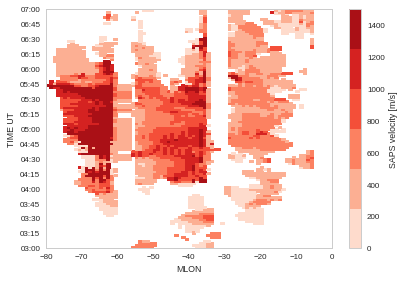

In [11]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
plotDF = sapsMLonTimeMaxDF[ ["time", "mlon_rnd",\
                        "west_vel"] ].pivot( "time", "mlon_rnd" )

timeVals = plotDF.index.values
mlonVals = plotDF.columns.levels[1].values

timeCntr, mlonCntr  = numpy.meshgrid( timeVals, mlonVals )
# Mask the nan values! pcolormesh can't handle them well!
vMagnVals = numpy.ma.masked_where(numpy.isnan(plotDF["west_vel"].values),plotDF["west_vel"].values)
rtiPlot = ax.pcolormesh(mlonCntr.T , timeCntr.T, vMagnVals,\
                        cmap=seaMap, vmin=velMagnScale[0],vmax=velMagnScale[1])

ax.set_ylim( [ timeStart, timeEnd ] )
ax.set_xlim( [ -80, 0 ] )
ax.set_ylabel("TIME UT")
ax.set_xlabel("MLON")
ax.get_yaxis().set_major_formatter(DateFormatter('%H:%M'))

ax.set_yticks(xTickList)

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("SAPS velocity [m/s]")
fig.savefig("../plots/sd-vels-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

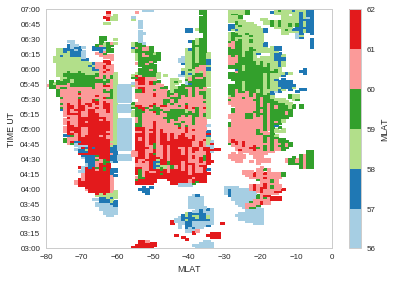

In [12]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Paired"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
plotDF = sapsMlatDF[ ["time", "mlon_rnd",\
                        "mlat_rnd"] \
                   ].pivot( "time", "mlon_rnd" )

timeVals = plotDF.index.values
mlonVals = plotDF.columns.levels[1].values

timeCntr, mlonCntr  = numpy.meshgrid( timeVals, mlonVals )
# Mask the nan values! pcolormesh can't handle them well!
vMagnVals = numpy.ma.masked_where(numpy.isnan(\
                plotDF["mlat_rnd"].values), plotDF["mlat_rnd"].values)
rtiPlot = ax.pcolormesh(mlonCntr.T , timeCntr.T, vMagnVals,\
                        cmap=seaMap, vmin=56., vmax=62.)

ax.set_ylim( [ timeStart, timeEnd ] )
ax.set_xlim( [ -80, 0 ] )
ax.set_ylabel("TIME UT")
ax.set_xlabel("MLAT")
ax.get_yaxis().set_major_formatter(DateFormatter('%H:%M'))

ax.set_yticks(xTickList)

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("MLAT")

fig.savefig("../plots/sd-vel-lats-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

In [13]:
# read from the feather file
lshellDF = feather.read_dataframe('../data/lshellFits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
lshellDF.head()

,azimSAPS,azimSTD,delMLT,goodFit,mlat,normMlt,velSAPS,velSTD,endPtMLAT,endPtNormMLT,date
0,-3.236139,1.387087,0.5,True,62.0,-5.0,646.002636,43.323736,62.04,-5.64,2016-07-25 04:06:00
1,-5.878198,2.760037,1.5,True,61.0,-4.0,620.821279,57.591342,61.06,-4.62,2016-07-25 04:06:00
2,-8.114615,3.692693,1.5,True,61.5,-5.0,514.861281,62.939880,61.57,-5.51,2016-07-25 04:06:00
3,-6.618126,1.352016,1.0,True,61.0,-5.0,422.839892,19.427486,61.05,-5.42,2016-07-25 04:06:00
4,-11.870053,2.809972,1.0,True,61.0,-3.0,749.034029,65.355440,61.15,-3.73,2016-07-25 04:06:00


In [14]:
lshellDF["endPtmlat"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["mlat"], 2)
lshellDF["endPtnormMlt"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["normMlt"], 2)
lshellDF = lshellDF.apply( get_mlon_from_mlt, axis=1 )

lshellDF.head()

,azimSAPS,azimSTD,delMLT,goodFit,mlat,normMlt,velSAPS,velSTD,endPtMLAT,endPtNormMLT,date,endPtmlat,endPtnormMlt,Mlon,EndptMlon
0,-3.236139,1.387087,0.5,True,62.0,-5.0,646.002636,43.323736,62.04,-5.64,2016-07-25 04:06:00,62.04,-5.64,-63.0,-72.0
1,-5.878198,2.760037,1.5,True,61.0,-4.0,620.821279,57.591342,61.06,-4.62,2016-07-25 04:06:00,61.06,-4.62,-48.0,-57.0
2,-8.114615,3.692693,1.5,True,61.5,-5.0,514.861281,62.939880,61.57,-5.51,2016-07-25 04:06:00,61.57,-5.51,-63.0,-70.0
3,-6.618126,1.352016,1.0,True,61.0,-5.0,422.839892,19.427486,61.05,-5.42,2016-07-25 04:06:00,61.05,-5.42,-63.0,-69.0
4,-11.870053,2.809972,1.0,True,61.0,-3.0,749.034029,65.355440,61.15,-3.73,2016-07-25 04:06:00,61.15,-3.73,-33.0,-44.0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


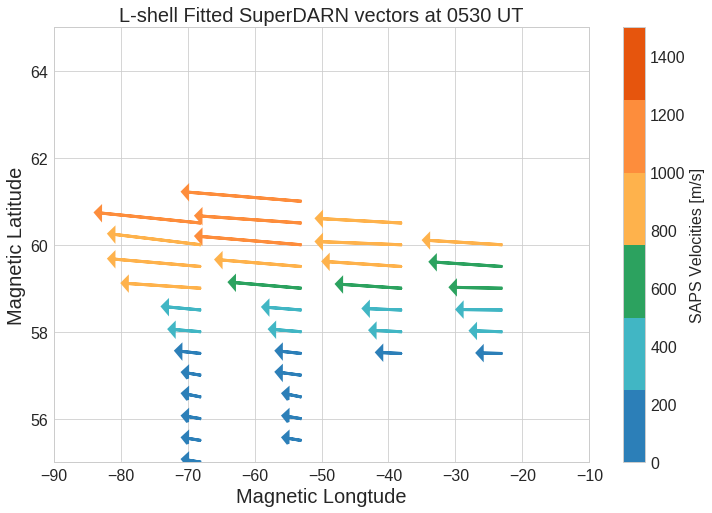

In [16]:
selTime = datetime.datetime(2016,7,25,5,30)
selSapsDF = lshellDF[ lshellDF["date"] == selTime ]
selSapsDF["SAPS speed [m/s]"] = selSapsDF["velSAPS"]
plotMLTends = selSapsDF['EndptMlon'].tolist()
plotmlatends = selSapsDF['endPtmlat'].tolist()
plotMLTbegins = selSapsDF['Mlon'].tolist()
plotmlatbegins = selSapsDF['mlat'].tolist()
plotVelMagns = selSapsDF['SAPS speed [m/s]'].tolist()


# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# lshlPlt = selSapsDF.plot( kind='scatter',
#               x='Mlon',
#               y='mlat',
#               c='SAPS speed [m/s]',
#               s=1., cmap=seaMap, vmin=velMagnScale[0],\
#               vmax=velMagnScale[1], ax=ax,fontsize=20)
lshellPlot = ax.scatter( x=selSapsDF["Mlon"], y=selSapsDF["mlat"],\
                     c=selSapsDF["SAPS speed [m/s]"],cmap=seaMap,\
                     vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

colNorm = Normalize( vmin=velMagnScale[0], vmax=velMagnScale[1] )
for currMLTend, currmlatend, currMLTbgn, currmlatbgn, currVel in\
        zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
#         ax.plot( [currMLTbgn, currMLTend], [ currmlatbgn, currmlatend ], color=currCol )        
        ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn, currmlatend-currmlatbgn,\
                 head_width=0.25, head_length=0.75, fc=currCol, ec=currCol, lw=3.)
    
ax.set_xlim( [-90,-10] )
ax.set_ylim( [ 55., 65. ] )
ax.set_ylabel( "Magnetic Latitude", fontsize=20 )
ax.set_xlabel( "Magnetic Longtude", fontsize=20 )
ax.set_title("L-shell Fitted SuperDARN vectors at " +\
             selTime.strftime("%H%M") + " UT", fontsize=20)

ax.tick_params(labelsize=16)
cb = plt.colorbar(lshellPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel('SAPS Velocities [m/s]', fontsize=16)
# cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
# fig.colorbar(lshellPlot, cax=cax, orientation='horizontal')

f.savefig("../plots/lshell-" +\
            selTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')